# Projeto 1 - Ciência dos Dados

### Alunos, digo, contratados da Apple :)

Nome: Fabio Dotoli Ferreira Filho

Nome: Livia Brigido do Nascimento

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

# INTRODUÇÃO:

#### Enunciado do projeto proposto: Você foi contratado por uma empresa para analisar como os clientes estão reagindo a umdeterminado produto no Twitter. A empresa deseja que você: crie um programa que selecionealgumas mensagens disponíveis no Twitter, as quais mencionam esse particular produto; e classifique esses tweets como "relevante" ou "irrelevante", pelo menos.

##### Os objetivos principais foram:
- Ter a primeira base de treinamento para o programa, ou seja, classificar à mão para servir de "exemplo" para a máquina;
- Juntamente à isso ter uma base de teste para colocar em prática o programa. Junto à ela uma classificação também feita à mão para fins de comparação;
- Limpar os dados da maneira que mais se encaixava com o nosso objetivo (Como por exemplo não apagar os emojis, mas considerá-los colocando espaços entre eles e as palavras;
- Enxergar a problemática que um termo exclusivo poderia trazer e, desse modo, adicionar a suavização (Laplace);
- Analisar as probabilidades de ser relevante ou não cada tweet;
- Finalizar com observações gerais sobre a atividade proposta.

___
Carregando algumas bibliotecas:

In [45]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from emoji import UNICODE_EMOJI  #Essa serve para quê mesmo?
import re #utilizaremos para limpar o texto ('replace')
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [46]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/fabiodff/Desktop/P1Cdados2021_2


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [47]:
filename = 'Airpods.xlsx'


In [48]:
#A de treinamento (A que será responsável pela ação de "ensinar" a máquina o que é ou não é relevante)

train = pd.read_excel(filename, sheet_name = 'Treinamento')
train.head(5)

,Treinamento,Classificacao_Treino
0,alguem me da um apple watch 😭😭😭😭 um macbook pr...,0
1,@hschmaiske @matheus1lva airpods pro é bom? é....,1
2,mais uns airpods estragados… que sorte 🤦🏻‍♂️,1
3,"@annaeso @masbahnana isso eu sei, mas nem espe...",0
4,sonhando com o dia que vou achar airpods por m...,1


In [49]:
#Observando a quantidade relativa das duas classificações:

train.Classificacao_Treino.value_counts(True) #Precisamos equilibrar um pouco mais esses dados:

0    0.633333
1    0.366667
Name: Classificacao_Treino, dtype: float64

In [50]:
#A de teste (Com a classficação que fizemos apenas para comparar com a futura ação da máquina)

test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Classificacao_Teste
0,"favela venceu, o pai lançou um airpods monstro...",0
1,"[weverse]\n\n“namjoon oppa, se eles lançarem a...",0
2,@priboechat comprei um fone tipo airpods e amei,0
3,@_army_brasileira_7 \n _army_brasileira_7 \n\n...,0
4,"@abelardo_moura ainda bem que foi o de fio, po...",0


In [51]:
#Observando a quantidade relativa das duas classificações:

test.Classificacao_Teste.value_counts(True)

0    0.713333
1    0.286667
Name: Classificacao_Teste, dtype: float64

___
## Classificador automático de sentimento


### Produto escolhido
* Os Airpods, lançamento da Apple no ano de 2016, são pequenos fones com conexão via bluetooth, que vêm acompanhados do estojo (usado para recarregá-los) e de um cabo lightning (carregador).

* Os tweets considerados relevantes foram aqueles que citavam alguma caracteristica relacionada ao produto escolhido, como por exemplo a durabilidade, a facilidade em perder os fones, preço e críticas/elogios aos Airpods como um todo.

* Os tweets irrelevantes, por sua vez, são aqueles que citam o produto, porém de uma forma que não é possivel extrair um feedback significativo sobre satisfação ou qualidades (positivas ou negativas) como, por exemplo, uma frase citando alguns itens aleatórios (dentre eles, os Airpods).

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [52]:
#Montando a função de limpeza principal e para a limpeza de palavras mais específicas** (cleanup)

def cleanup_emoji(emoji1):
    return emoji1 in UNICODE_EMOJI

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '["\/!-.:?;"]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text) #substitui o primeiro argumento pelo segundo, e o terceiro argumento é onde será aplicada a substituição
    text_subbed = re.sub('\n', ' ', text_subbed) #retirando o enter (pular para a próxima linha)
    text_subbed = ''.join(' ' + char + ' ' if cleanup_emoji(char) else char for char in text_subbed).strip()

    
    padrao = r'https\w+'
    pattern2 = re.compile(padrao)
    text_subbed2 = re.sub(pattern2, '', text_subbed)
    
    return text_subbed2.lower()


def cleanup_links(text):
    
    padrao1 = r'@\w+' #remove o símbolo ou escrita e as letras após ele
    pattern1 = re.compile(padrao1)
    text_subbed = re.sub(pattern1, '', text)  
    
    padrao3 = r'#\w+'
    pattern3 = re.compile(padrao3)
    text_subbed3 = re.sub(pattern3, '', text_subbed)
    
    padrao4 = r'&\w+'
    pattern4 = re.compile(padrao4)
    text_subbed4 = re.sub(pattern4, '', text_subbed3)
    
    padrao5 = r'_\w+'
    pattern5 = re.compile(padrao5)
    text_subbed5 = re.sub(pattern5, '', text_subbed4)
    
    
    
    return text_subbed5



def stopwords_funcao(texto):
    stop_words = (nltk.corpus.stopwords.words('portuguese'))
    
    stopwords_lista = []
    
    for palavras in texto:
        if palavras not in stop_words: 
            stopwords_lista.append(palavras)
    
    return stopwords_lista

##### Limpando e realizando o split nos tweets relevantes:

In [53]:
#já foi dividido em rel. e irrel. pois depois não será possivel dividir por ser um df de apenas uma coluna 
train_relevantes_clean = train.loc[train["Classificacao_Treino"] == 1, 'Treinamento'].apply(cleanup_links).apply(cleanup)


In [54]:
train_relevantes_lower = train_relevantes_clean.str.lower() #por que usar o .str ao inves de uma variavel-- Não quero trabalhar no dataset,mas em cada linha.
train_relevantes = train_relevantes_lower.str.split()
train_relevantes_clean = train_relevantes.apply(stopwords_funcao)

In [55]:
type(train_relevantes_clean)

pandas.core.series.Series

In [56]:
train_relevantes_l = []  #criando uma lista para englobar todas as outras listas criadas com o .split

for palavras in train_relevantes_clean:
    train_relevantes_l += palavras
serie_train_relevantes = pd.Series(train_relevantes_l)

In [57]:
serie_train_relevantes_absoluta = serie_train_relevantes.value_counts()

##### Limpando e realizando o split nos tweets irrelevantes:

In [58]:
train_irrelevantes_clean = train.loc[train["Classificacao_Treino"] == 0, 'Treinamento'].apply(cleanup_links).apply(cleanup)


In [59]:
train_irrelevantes_lower = train_irrelevantes_clean.str.lower() 
train_irrelevantes = train_irrelevantes_lower.str.split()
train_irrelevantes_clean = train_irrelevantes.apply(stopwords_funcao)

In [60]:
type(train_irrelevantes_clean)


pandas.core.series.Series

In [61]:
train_irrelevantes_l = []  #criando uma lista para englobar todas as outras listas criadas com o .split

for palavras in train_irrelevantes_clean:
    train_irrelevantes_l += palavras
serie_train_irrelevantes = pd.Series(train_irrelevantes_l)

In [62]:
serie_train_irrelevantes_absoluta = serie_train_irrelevantes.value_counts()

In [63]:
test["Teste"] = test["Teste"].apply(cleanup_links).apply(cleanup) #atualizar dataframe

In [64]:
train["Treinamento"]= train["Treinamento"].apply(cleanup_links).apply(cleanup)

### Implementando a suavização de Laplace :


In [65]:
train_tamanho_irrelevantes = len(serie_train_irrelevantes_absoluta)
train_tamanho_irrelevantes

1582

In [66]:
train_tamanho_relevantes = len(serie_train_relevantes_absoluta)
train_tamanho_relevantes

1063

In [67]:
Dimensao = train_tamanho_irrelevantes + train_tamanho_relevantes
D= Dimensao #Dimensão do nosso "universo" de palavras e emojis.

In [68]:
#Quantidade total de palavras em relevantes:
Nr= len(train_relevantes_l)
Nr

2206

In [69]:
#Quantidade total de palavras em irrelevantes:
Ni= len(train_irrelevantes_l)
Ni

4265

##### Explicação das três variáveis criadas:

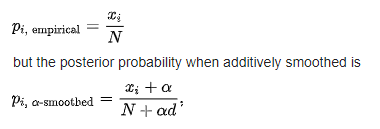

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [70]:
#Função que será executada com "apply":
def classificador_suavizado(tweet):
    prob_relevante=1
    prob_irrelevante=1
    alpha= 1
    lista_palavras = tweet.split()
    for palavra in lista_palavras:
        
        #Como vimos que, quando o termo não existia na lista, dava erro pois não se igualava à zero automaticamente:
        if palavra not in train_relevantes_l:
            serie_train_relevantes_absoluta[palavra]=0
        
        elif palavra not in train_irrelevantes_l:
            serie_train_irrelevantes_absoluta[palavra]=0
            
        if palavra in train_relevantes_l and palavra in train_irrelevantes_l:
            prob_relevante*= (serie_train_relevantes_absoluta[palavra]+1)/ (Nr+D)
            prob_irrelevante*= (serie_train_irrelevantes_absoluta[palavra]+1)/ (Ni+D)
        
    #Em vez do que está abaixo, acrescentar em uma coluna nova a classficação feita pela maquina (Para comparar posteriormente com a nossa feita à mão)
    if prob_relevante>prob_irrelevante:
        return 1
    else:
        return 0

In [71]:
test["classificacao_modelo"]= test["Teste"].apply(classificador_suavizado)


In [72]:
test["classificacao_modelo"].value_counts(True)


0    0.67
1    0.33
Name: classificacao_modelo, dtype: float64

In [73]:
test


,Teste,Classificacao_Teste,classificacao_modelo
0,favela venceu o pai lançou um airpods monstro,0,0
1,[weverse] “namjoon oppa se eles lançarem airp...,0,0
2,comprei um fone tipo airpods e amei,0,1
3,army se você sair do airpods 3você não vive ...,0,0
4,ainda bem que foi o de fio porque se fosse os ...,0,0
...,...,...,...
295,vou querer um macbook um ipad um airpods um ap...,0,0
296,meu airpods até caiu da orelha,0,1
297,anonymous vazem o número do cartão do bolsonar...,0,0
298,meus airpods tão com o volume baixo,1,0


In [74]:
#Ver qual foi a distribuição do modelo
test["classificacao_modelo"].value_counts(True)

0    0.67
1    0.33
Name: classificacao_modelo, dtype: float64

In [75]:
#Ver a distribuição que colocamos
test["Classificacao_Teste"].value_counts(True)

0    0.713333
1    0.286667
Name: Classificacao_Teste, dtype: float64

#### Porcentagem de erros e acertos:


In [76]:
#Matriz de confusão
mat_porcentagem=pd.crosstab(test.Classificacao_Teste, test.classificacao_modelo, normalize=True)*100 #Multiplicar po 100 porque é porcentagem!
mat_porcentagem

classificacao_modelo,0,1
Classificacao_Teste,,
0,55.0,16.333333
1,12.0,16.666667


## Acurácia:

In [77]:
#Será aquelas em que ambos marcaram 0 e 1:
acuracia= mat_porcentagem[0][0]+mat_porcentagem[1][1]  #Coluna/ linha
acuracia.round(3)

71.667

___
### Concluindo

A performance do classificador Naïve Bayes construído foi mediana, com 71.67% de acurácia, 16.33% de falsos negativos e 12% de falsos negativos, sendo assim considerado levemente satisfatório. Podemos concluir também que a base de dados utilizada poderia ser melhor se buscada em outros locais como sites de reviews, por se tratar de um ambiente unicamente utilizado com a função de dar feedback sobre a experiência do usuário com o produto adquirido. Informações relevantes foram obtidas a partir da pesquisa, como durabilidade e preço do produto, facilidade de se perder um dos fones ou a case e a recorrência de problemas quanto à qualidade do mesmo. É importante ressaltar novamente que o Twitter não é a melhor rede social para buscar tais feedbacks para os produtos, devido à grande quantidade de informações irrelevantes, como frases sem sentido, em outro idioma ou se referindo à produtos falsificados.
O projeto em questão deve continuar sendo financiado pela *Apple.inc* a fim de coletar dados de feedback de lançamentos e produtos já lançados em busca de futuras melhorias e de manter o que já é bem aceito pelo público consumidor, buscando compreender a forma que os produtos impactam os sentimentos do público. 
Mensagens com conteúdo sarcástico são analisadas ao pé da letra pelo classificador, dado que ele considera todas as palavras de um tweet de forma independente umas das outras. Já mensagens com dupla negação são consideradas de forma negativa, pois cada palavra é considerada de forma independente do restante da frase.


___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste


In [78]:
def classificador_suavizado_geral(tweet):
    prob_relevante=1
    prob_irrelevante=1
    alpha= 1
    lista_palavras = tweet.split()
    for palavra in lista_palavras:
        
        #Como vimos que, quando o termo não existia na lista, dava erro pois não se igualava à zero automaticamente:
        if palavra not in train_r_l:
              train_r_abs[palavra]=0
        
        elif palavra not in train_i_l:
              train_i_abs[palavra]=0
            
        if palavra in train_i_l and palavra in train_r_l:
            prob_relevante*= (train_r_abs[palavra]+1)/ (Nr+D)
            prob_irrelevante*= (train_i_abs[palavra]+1)/ (Ni+D)
        
    #Em vez do que está abaixo, acrescentar em uma coluna nova a classficação feita pela maquina (Para comparar posteriormente com a nossa feita à mão)
    if prob_relevante>prob_irrelevante:
        return 1
    else:
        return 0

In [79]:
testcopy= test.drop(["classificacao_modelo"], axis=1)
testcopy= testcopy.rename(columns={"Teste": "Treinamento", "Classificacao_Teste": "Classificacao_Treino"})
traincopy= train.copy()
novoframe= pd.concat([traincopy, testcopy], ignore_index=True)

In [80]:
all_i = novoframe.loc[novoframe["Classificacao_Treino"] == 0 , :].copy()
all_i["Treinamento"] = all_i.loc[:, 'Treinamento'].apply(cleanup_links).apply(cleanup)

all_r = novoframe.loc[novoframe["Classificacao_Treino"] == 1, :].copy()
all_r["Treinamento"] = all_r.loc[: , "Treinamento"].apply(cleanup_links).apply(cleanup)

In [81]:

def dividir(all_i, all_r):
    #Separar aleatoriamente as listas- USO DE SPLIT SKLEARN
    test_random_i, train_random_i=train_test_split(all_i, test_size=0.33,  train_size=1-0.33, shuffle=True)     
    test_random_r, train_random_r=train_test_split(all_r, test_size=0.33,  train_size=1-0.33, shuffle=True) 
    todos= [test_random_r, train_random_r, test_random_i, train_random_i]

In [82]:
acertos_lista=[]
erros_lista=[]

for i in range (0,100): 
    lista_randomizada= dividir(all_i, all_r)
    test_random_r= lista_randomizada[1]
    train_random_r= lista_randomizada[2]
    test_random_i= lista_randomizada[3]
    train_random_i=lista_randomizada[4]
    
    test_random=pd.concat([test_random_i,test_random_r],ignore_index=True)
    train_random=pd.concat([train_random_i,train_random_r],ignore_index=True)
    
    train_random_i_lower = train_random_i["Treinamento"].str.lower()
    train_random_i_split=train_random_i_lower.str.split()
    train_random_i_clean = train_random_i_split.apply(stopwords_funcao)
    
    train_random_r_lower = train_random_r["Treinamento"].str.lower()
    train_random_r_split= train_random_r_lower.str.split()
    train_random_r_clean = train_random_r_split.apply(stopwords_funcao)
    
    train_r_l=[]
    train_i_l=[]
    
    for palavras in train_random_r_clean:
        train_r_l += palavras
    for palavras in train_random_i_clean:
        train_i_l += palavras
        
    serie_train_r = pd.Series(train_r_l)
    serie_train_i = pd.Series(train_i_l)
    
    train_i_abs=serie_train_i.value_counts()
    train_r_abs=serie_train_r.value_counts()
    
    
    Nr= len(train_r_l)
    Ni= len(train_i_l)
   
    
    #Aplicar função:
    test_random["classificacao_modelo"]= test_random["Treinamento"].apply(classificador_suavizado_geral)
    
    
    #Retornar
    mat_porcentagem01=pd.crosstab(test_random.Classificacao_Treino, test_random.classificacao_modelo, normalize=True)*100 
    acertos= mat_porcentagem01[1][1] + mat_porcentagem[0][0]
    erros= 100-acertos
    
    
    #Listas para o histograma
    acertos_lista.append(acertos)
    erros_lista.append(erros)
    

TypeError: 'NoneType' object is not subscriptable

### Construindo o histograma da qualidade do classificador:¶


In [42]:
plt.figure(figsize=(15, 5))

print(acertos_lista[0]+erros_lista[1])

plt.subplot(121) 
plt.hist(erros_lista, edgecolor='white', color='red',density=True)
plt.title('Porcentagem de erros')
plt.ylabel('Densidade')

plt.subplot(122) 
plt.hist(acertos_lista , edgecolor='white', color="green",density=True)
plt.title('Porcentagem de acertos')
plt.ylabel('Densidade')

IndexError: list index out of range

<Figure size 1080x360 with 0 Axes>

Feito isso, podemos observar a partir dos histogramas construídos que uma classificação única não é recomendável, uma vez que é possivel observar uma flutuação nas porcentagens de erros-acertos. Portanto, esse processo de randomização e classificação feito várias vezes nos permite observar uma abrangência maior da acurácia do classificador. Quanto mais repetições houver nesse processo, melhor.

### Sugestão e implementação de melhorias no classificador:

* Utilizar mais fontes dos comentários (Youtube, facebook, instagram...) E comparar para descobrir qual fonte apresenta uma possibiidade maior de oferecer comentarios relevantes. Utilizar funções diferentes do pandas, pois cada plataforma possui um tipo de renderização diferente. (Para o YouTube, por exemplo, o selenium seria a biblioteca mais indicada)

* Na função de limpeza stopwords acrescentar as abreviações mais comuns do português nas redes sociais. Com a função .extend do stopwords é possivel criar uma lista de palavras novas a serem retiradas do texto alvo.


*Material de pesquisa*: 
* https://www.projectpro.io/recipes/add-custom-stopwords-and-then-remove-them-from-text
* https://towardsdatascience.com/how-to-scrape-youtube-comments-with-python-61ff197115d4

### Por quê não se pode usar o classificador para gerar mais amostras?

• Não se pode usar o classificador para gerar mais amostras de treinamento pois recai em um ponto não desejado em uma análise de probabilidades: Enviezar a pesquisa. A base de treinamento é elaborada da forma mais confiável possível, nesse caso, elaborada diretamente por seres humanos, que conseguem, a partir de sua interpretação de cada amostra, mostrar exatamentente quais são as informações relevantes ou não.

Quando se trata do classificador já é implementada a noção de probabilidade, o que já abre espaço para erros. Dessa forma, usando o classificador para gerar mais amostras leva a conclusão de que as classificações incorretas, que podem ser cometidas, serão perpetuadas por todos os futuros processos com a ferramenta.

### Diferentes cenários para a aplicação de Naïve Bayes:


• Naive Bayes pode ser implementado quando há a necessidade de se diferenciar e-mails comuns, e-mails com assuntos voltados a business, e-mails voltados a notícias ou e-mails que são SPAM.

• Utilizar Naive Bayes para se ter um panorama da probabilidade de contágio ou não-contágio de pessoas expostas ao coronavírus, baseando-se em características fisiológicas de cada uma, por exemplo.

• Classificar a faixa etária de um público com base no vocabulário e abreviações utilizadas nas redes sociais.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords

* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis

* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento

* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto

* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)

* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)
_____________________________________________________________________________________________________________________

* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**